# Pittsburgh Intersection Threat Assessment System (PITAS)
## an automated inspection system 

<br />

### Introduction:
Despite innovations in automotive safety features and traffic control systems, automotive collisions remain one of the most costly and dangerous problems in the United States. Intersections are particularly dangerous and are where over 40% of traffic collisions occur. In my project, **Pittsburgh Intersection Threat Assessment System (PITAS)**, I propose using city data on traffic collisions, intersection safety features, and intersection geometry to predict the number of collisions that will occur at all intersections of a city, determine which features contribute the most to each intersection’s safety rating, and allow city planners to interact with the model. **PITAS could be productized as a municipal decision assistance tool or a tool to help insurance companies set premiums.**

<br />

### Inputs:

**PITAS** recieves inputs from several disparate datasets:

- Road centerline shapes, road names, speed limits, one way status ([link](https://www.pasda.psu.edu/uci/DataSummary.aspx?dataset=1224))
- Traffic Sign descriptions and locations ([link](https://data.wprdc.org/dataset/city-traffic-signs))
- Traffic Light descriptions and locations ([link](https://data.wprdc.org/dataset/city-of-pittsburgh-signalized-intersections))
- Detailed accident descriptions including locations ([link](https://data.wprdc.org/dataset/allegheny-county-crash-data))
- Zoning information ([link](https://data.wprdc.org/dataset/zoning1))
- 311 Complaint information ([link](https://data.wprdc.org/dataset/311-data))

The ultimate input will combine this information as the following features:

<br />

### Model:
The inputs are fed into a Random Forest Multilabel Classification Model with 3 possible Risk Levels / labels:

1: 0 Accidents Per Year
2: 0-2 Accidents Per Year
3: >2 Accidents Per Year

This values are generated for each intersection, which serves as the output of the model.

<br />

### Interactivity:

**PITAS** is hosted at [pitas.herokuapp.com](pitas.herokuapp.com). At the site, you can toggle different features of a particular intersection to see how this could affect the Risk Level. 

To confine this analysis 

<br />

Using this data as well as published descriptors of the interesections (totaling **303MB of data processed**), I have created a preliminary Ridge Regression model to predict the number of accidents that have occurred at each intersection in Pittsburgh from 2004-2017. In the first portion of this project, I used geospatial data of street centerlines to define all interesections in Pittsburgh. This is shown below, with each intersection also showing how many accidents have occurred there from 2004-2017:


### Import Libraries and Engineering Features
<br />
In the next portion, I engineered features from data describing Pittsburgh intersection. The the features that were ultimately selected are listed below:

In [2]:
import os
import numpy as np
import pandas as pd
from six.moves import urllib
from math import sin, cos, asin, sqrt, degrees, radians
import ast

%matplotlib inline
import matplotlib.pyplot as plt

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

path = os.getcwd()
newouts = pd.read_csv(os.path.dirname(path)+r'/data_checkpoints/ModelDf.csv')
newouts.set_index('IntCode',inplace=True)

In [2]:
newouts.drop(columns=['numacc','ZipCode'],inplace=True)
#newouts.ZipCode=newouts.ZipCode.apply(lambda x: int(x.strip("""[]''""")))
newouts.StopPerWay.fillna(0, inplace=True)
newouts.TrafficFlash.fillna(0, inplace=True)
newouts.AccOverTime=newouts.AccOverTime.apply(lambda x: ast.literal_eval(x))
newouts.STlist=newouts.STlist.apply(lambda x: ast.literal_eval(x))
newouts['numacc']= newouts.AccOverTime.apply(lambda x: sum(x[9:])/5) #New Calculation of accidents over time
newouts.drop(columns=['latitude','longitude','AccOverTime','STlist','STstr'],inplace=True)
newouts.head()


,numones,meanspeed,maxdiffspeed,numroad,uniroad,StopSign,StopPerWay,TrafficLight,TrafficFlash,turnrestriction,...,Educational/Medical_Institution,Two-Unit_Residential,General_Industrial,Planned_Unit_Development,Single-Unit_Detached_Residential,General_Industrial__,Highway_Commercial,Three-Unit_Residential,Neighborhood_Office,numacc
IntCode,,,,,,,,,,,,,,,,,,,,,
1,0,25.000000,0.0,3.0,2.0,0,0.0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,0,28.333333,10.0,6.0,2.0,0,0.0,1,0.0,5,...,0,0,0,0,0,0,0,0,0,2.4
3,2,30.000000,10.0,4.0,2.0,0,0.0,1,0.0,2,...,0,0,0,0,0,0,0,0,0,0.8
4,0,25.000000,0.0,5.0,2.0,1,2.5,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0.0
5,0,30.000000,10.0,4.0,2.0,0,0.0,1,1.0,1,...,0,0,0,0,0,0,0,0,0,1.6


In [3]:
newouts.numacc.describe()

count    10343.000000
mean         0.199111
std          0.750885
min          0.000000
25%          0.000000
50%          0.000000
75%          0.200000
max         29.200000
Name: numacc, dtype: float64

In [3]:
newouts['numacc2']=0
newouts.numacc2[newouts.numacc==0.0]=1
#newouts.numacc2[(newouts.numacc>0.0)&(newouts.numacc<=1.0)]=2
newouts.numacc2[(newouts.numacc>0.0)&(newouts.numacc<=2.0)]=2
newouts.numacc2[(newouts.numacc>2.0)]=3
newouts.drop(columns=['numacc'],inplace=True)

C:\Users\james\Anaconda3\envs\mlbook\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\james\Anaconda3\envs\mlbook\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\james\Anaconda3\envs\mlbook\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [4]:
#proportions of groups
(newouts.numacc2.value_counts().values)/(newouts.numacc2.value_counts().values.sum())

array([0.74320797, 0.23784202, 0.01895001])

In [5]:
for xx in range(0,10,1):
    print(xx,sum((newdf.numacc<=xx)&(newdf.numacc>xx-1)))

NameError: name 'newdf' is not defined

<br /> 
The Pearson's correlation coefficent matrix of these features shows that many of the features--especially presence of a traffic light at the intersection and the number of signs at the intersection--are correlated with the total number of accidents (numacc): 

In [ ]:
#newdf.rename(index=str, columns={"numones": "num1Ways", "numroads": "numRoads", "uniroad": "numUniqueRoads", "numacc": "numAccidents"})

In [17]:
newouts.columns

Index(['numones', 'meanspeed', 'maxdiffspeed', 'numroad', 'uniroad',
       'StopSign', 'StopPerWay', 'TrafficLight', 'TrafficFlash',
       'turnrestriction', 'noparking', 'vissigns', 'yielding', 'Complaints311',
       'Golden_Triangle_', 'Local_Neighborhood_Commercial_',
       'Neighborhood_Industrial', 'Single-Unit_Attached_Residential',
       'Urban_Industrial', 'Hillside__', 'Specially_Planned',
       'Multi-Unit_Residential', 'Urban_Neighborhood_Commercial', 'Parks',
       'Educational/Medical_Institution', 'Two-Unit_Residential',
       'General_Industrial', 'Planned_Unit_Development',
       'Single-Unit_Detached_Residential', 'General_Industrial__',
       'Highway_Commercial', 'Three-Unit_Residential', 'Neighborhood_Office',
       'numacc2'],
      dtype='object')

In [ ]:
boi = newdf[newdf.columns[0:]].corr()['numacc']
boiind = ['No. of One Ways','Mean Speed of Roads','Largest Speed Differential','No. of Roads at Int.',
          'No. Unique Roads at Int.','Stop Signs','No. Stop Signs per Way','Traffic Lights','Flashing Traffic Light',
          'No. Relevant Signs','Number of Accidents at Int.']
boi.values

dispArray = pd.DataFrame({'Variables' : boiind, 'Rsq' : boi.values})
dispArray.sort_values(by=['Rsq'],ascending=False,inplace=True)
dispArray.drop([10])

In [ ]:
print(newdf[newdf.columns[0:]].corr()['numacc'])
corrmat = newdf.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cmap='coolwarm', vmax=1, square=True); 

<br />
In addition to these features, some of the categorical features that I have extracted seem to be predictive of the number of collisions. For instance, Zip Code seems to capture some variance in the data, as shown by this map:


### Data Cleaning
<br />
Having shown some preliminary validation of our parameter selection, I will move forward with the model. The first step is to clean the data by filling NaNs, label encoding categorical columns, creating a test set, and scaling the data:


In [4]:
#Clean up the data

#newdf = pd.get_dummies(newdf, columns=['TrafficFlash'])

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(newouts, newouts["numacc2"]):
    train_full = newouts.iloc[train_index]
    test_full = newouts.iloc[test_index]

print(train_full.numacc2.value_counts())
print(test_full.numacc2.value_counts())


trainY = train_full.numacc2
train_full.drop(columns=['numacc2'], inplace=True)
testY = test_full.numacc2
test_full.drop(columns=['numacc2'], inplace=True)



1    6149
2    1968
3     157
Name: numacc2, dtype: int64
1    1538
2     492
3      39
Name: numacc2, dtype: int64


C:\Users\james\Anaconda3\envs\mlbook\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [5]:
#Scale the data
scaler = StandardScaler()
train_full = scaler.fit_transform(train_full)
test_full = scaler.fit_transform(test_full)

C:\Users\james\Anaconda3\envs\mlbook\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\james\Anaconda3\envs\mlbook\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\james\Anaconda3\envs\mlbook\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\james\Anaconda3\envs\mlbook\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [6]:
trainY=trainY.astype('int')
testY=testY.astype('int')

### Classification Model Training and Evaluation

Though I have not examined the full set of features that I initially set out to use, I want to train a model to see how well I can predict the number of collisions in intersections using the current set of features. For this, I have chosen to use a Ridge Regression with cross validation to optimize the regularization hyperparameter. This was selected as a first-pass model as it is not highly prone to overfitting, but it may also not capture complex, non-linear relationships between features:

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [10]:

# Create the parameter grid based on the results of random search 
param_grid2 = {
    'class_weight': ['balanced'],
    'max_depth': [60, 80,100],
    'max_features': [6,8,10],
    'min_samples_leaf': [2,3,4,5],
    'min_samples_split': [12,14,16],
    'n_estimators': [100, 200, 300]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid2, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [11]:
grid_search.fit(train_full,trainY)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:  6.7min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'class_weight': ['balanced'], 'max_depth': [60, 80, 100], 'max_features': [6, 8, 10], 'min_samples_leaf': [2, 3, 4, 5], 'min_samples_split': [12, 14, 16], 'n_estimators': [100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [12]:
grid_search.best_params_ #USE THIS BAD BOI!!! 

{'class_weight': 'balanced',
 'max_depth': 80,
 'max_features': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 300}

In [26]:
finRF = RandomForestClassifier(class_weight='balanced',n_estimators=300, max_depth=80, min_samples_split=12, min_samples_leaf=2,max_features=6)

In [28]:
finRF.fit(train_full,trainY)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=80, max_features=6,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=12, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [29]:
#fit the model to the data
#clf = RidgeCV(alphas=np.arange(.1,20,.1)).fit(train_full, trainY)
#clf.score(train_full, trainY)

#Evaluate the fit:
training_predictions = finRF.predict(train_full)
#mse = mean_squared_error(trainY, training_predictions)
#rmse = np.sqrt(mse)
#print('Root mean square error of the training set: ', rmse)


#Use our test set to evaluate the model:
test_predictions = finRF.predict(test_full)
#mse_test = mean_squared_error(testY, test_predictions)
#rmse_test = np.sqrt(mse_test)
#print('Root mean square error of the test set: ',rmse_test)
print('Train score: ',finRF.score(train_full,trainY),' Test score: ',finRF.score(test_full,testY))

Train score:  0.834783659656756  Test score:  0.7723537941034316


In [12]:
from sklearn.metrics import classification_report
print(classification_report(testY, test_predictions))

              precision    recall  f1-score   support

           1       0.87      0.84      0.86      1538
           2       0.52      0.57      0.54       492
           3       0.46      0.64      0.54        39

   micro avg       0.77      0.77      0.77      2069
   macro avg       0.62      0.68      0.65      2069
weighted avg       0.78      0.77      0.78      2069



In [13]:
((test_predictions-testY).value_counts())/((test_predictions-testY).value_counts().sum())

 0    0.771870
 1    0.129048
-1    0.097632
 2    0.001450
Name: numacc2, dtype: float64

In [24]:
tmpacc = newdf.numacc2
newdf.drop(columns=['numacc2'], inplace=True)

In [42]:
newdf = scaler.fit_transform(newdf)

C:\Users\james\Anaconda3\envs\mlbook\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\james\Anaconda3\envs\mlbook\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [46]:
finRF.feature_importances_

array([0.05078359, 0.18378635, 0.03834269, 0.06161004, 0.02600788,
       0.02112715, 0.05459664, 0.11193104, 0.01469459, 0.04714804,
       0.03346851, 0.00022247, 0.0154305 , 0.16138104, 0.00798855,
       0.02332337, 0.00463648, 0.01234899, 0.01600523, 0.01078083,
       0.00179276, 0.01713534, 0.01195324, 0.01623933, 0.0040698 ,
       0.01798184, 0.00036232, 0.00461536, 0.02413326, 0.00157146,
       0.00106174, 0.00310846, 0.00036109])

In [30]:
# from sklearn.externals import joblib
# joblib.dump(finRF, 'RFmod20190726_e.sav')
# #loaded_model = pickle.load(open(filename, 'rb'))

['RFmod20190726_e.sav']

In [52]:
import pickle
pickle.dump(finRF, open('RFmod20190726_f.sav', 'wb'))

In [53]:
# from sklearn.externals import joblib
# loaded_model = joblib.load('RFmod20190726_e.sav')
import pickle
loaded_model = pickle.load(open('RFmod20190726_f.sav', 'rb'))

In [54]:
loaded_model

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=80, max_features=6,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=12, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [6]:
#Base inputs for the model
modins = pd.read_csv('modelinputs.csv')
modins.set_index('IntCode',inplace=True)
scaler = StandardScaler()
scalemodin = scaler.fit_transform(modins)

C:\Users\james\Anaconda3\envs\mlbook\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\james\Anaconda3\envs\mlbook\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [37]:
keymets = pd.read_csv('keymets.csv')
keymets.set_index('IntCode',inplace=True)
keymets.head()

,latitude,longitude,AccOverTime
IntCode,,,
1,40.444068,-79.995431,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,40.444456,-79.995609,"[0, 0, 0, 4, 0, 0, 1, 2, 2, 1, 2, 3, 3, 3]"
3,40.446443,-79.996514,"[0, 0, 0, 0, 3, 0, 0, 1, 1, 0, 0, 2, 2, 0]"
4,40.444930,-79.996041,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
5,40.429414,-79.988609,"[0, 0, 0, 0, 0, 2, 1, 2, 0, 4, 0, 2, 0, 2]"


In [33]:
float(str(modins.meanspeed[899]))

30.0

In [65]:
hi = '30.0'
nhi = []
try:
    nhi=float(hi)
except:
    pass

if nhi:
    print(nhi)

30.0


In [40]:
newouts = pd.read_csv(os.path.dirname(path)+r'/data_checkpoints/prelim_dashboard_dataC.csv')
newouts.set_index('IntCode',inplace=True)

In [66]:
modins.maxdiffspeed[899]

10.0

In [21]:
scaler.transform(hi.values.reshape(1, -1))

array([[ 1.1965191 ,  0.63163981,  0.60763271,  0.47470204, -0.36454582,
         1.19377047, -0.6842908 ,  3.89695118,  8.56796778,  6.47711417,
        -0.37584494, -0.09190325, -0.1290704 ,  0.67612535, -0.1511428 ,
        -0.44381071, -0.12810606, -0.42017162, -0.25853158, -0.35282231,
        -0.10603605, -0.36500832, -0.19017123, -0.36823237, -0.15834876,
         2.13279623, -0.0717679 , -0.18267448, -0.86898401, -0.09102865,
        -0.0904872 ,  9.30873474, -0.06308573]])

In [28]:
intnum=899
(modins.TrafficLight[intnum]==1)&(modins.TrafficFlash[intnum]==0)

# if modins.TrafficLight[intnum]==1&modins.TrafficFlash[intnum]==0:
#     print('hi')

False

In [36]:
scaler = StandardScaler()
train_full = scaler.fit_transform(modinputs)

C:\Users\james\Anaconda3\envs\mlbook\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\james\Anaconda3\envs\mlbook\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [69]:
howdy = ['RT','WR']

if 'R' in howdy:
    print('peppz')

In [48]:
int(loaded_model.predict(train_full[2-1].reshape(1, -1))[0])

3

In [70]:
modins.columns

Index(['numones', 'meanspeed', 'maxdiffspeed', 'numroad', 'uniroad',
       'StopSign', 'StopPerWay', 'TrafficLight', 'TrafficFlash',
       'turnrestriction', 'noparking', 'vissigns', 'yielding', 'Complaints311',
       'Golden_Triangle_', 'Local_Neighborhood_Commercial_',
       'Neighborhood_Industrial', 'Single-Unit_Attached_Residential',
       'Urban_Industrial', 'Hillside__', 'Specially_Planned',
       'Multi-Unit_Residential', 'Urban_Neighborhood_Commercial', 'Parks',
       'Educational/Medical_Institution', 'Two-Unit_Residential',
       'General_Industrial', 'Planned_Unit_Development',
       'Single-Unit_Detached_Residential', 'General_Industrial__',
       'Highway_Commercial', 'Three-Unit_Residential', 'Neighborhood_Office'],
      dtype='object')

In [50]:
keymets.head()

,IntCode,latitude,longitude,AccOverTime
0,1,40.444068,-79.995431,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,2,40.444456,-79.995609,"[0, 0, 0, 4, 0, 0, 1, 2, 2, 1, 2, 3, 3, 3]"
2,3,40.446443,-79.996514,"[0, 0, 0, 0, 3, 0, 0, 1, 1, 0, 0, 2, 2, 0]"
3,4,40.444930,-79.996041,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,5,40.429414,-79.988609,"[0, 0, 0, 0, 0, 2, 1, 2, 0, 4, 0, 2, 0, 2]"


In [24]:

cols2 = ['Number of One Ways','Mean Speed of Roads','Max. Difference in Speed of Roads','Number of Roads',
        'Number of Uniquely Named Roads','Stop Sign Intersection','Stop Signs Per Road','Traffic Light Intersection',
         'Dynamic Traffic Signal','Turn Restrictions','Parking Restrictions at Intersection',
         'Warning Signs Present','Yielding Signs Present','Number of 311 Complaints']+list(newdf.columns[15:])




In [45]:
# feature_importances = pd.DataFrame(grid_search.best_estimator_.feature_importances_, index = cols2, 
#                                    columns=['Relative Importance']).sort_values('Relative Importance', ascending=False)

feature_importances = pd.DataFrame(finRF.feature_importances_, index = cols2, 
                                   columns=['Relative Importance']).sort_values('Relative Importance', ascending=False)

feature_importances

NameError: name 'cols2' is not defined

In [33]:
FI = feature_importances.iloc[:10]
FI

,Relative Importance
Mean Speed of Roads,0.220073
Traffic Light Intersection,0.184699
Number of 311 Complaints,0.141456
Turn Restrictions,0.070707
Max. Difference in Speed of Roads,0.069884
Number of Roads,0.057619
Stop Signs Per Road,0.053569
Stop Sign Intersection,0.039694
Number of One Ways,0.027194
Parking Restrictions at Intersection,0.016754


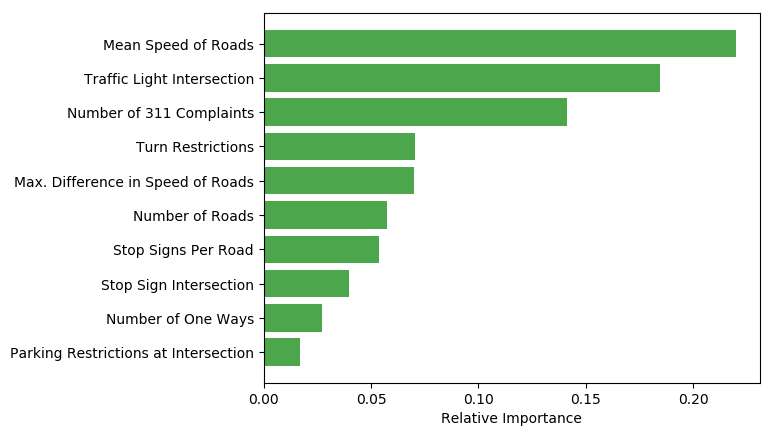

In [43]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(1,11)

ax.barh(y_pos, FI['Relative Importance'].values, align='center',color='#4CA64C')
ax.set_yticks(y_pos)
ax.set_yticklabels(FI.index)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Relative Importance')


plt.show()

This pickled model is what is used in the dashboard application. It is unpickled in app.py and implemented from there!